## 2. Get the data 

In [1]:
import os
import tarfile
import urllib

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
# Fetch data available online
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

In [4]:
# Import the data into a pandas dataframe
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
len(housing)

20640

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


# 3. Create the test data 

In [ ]:
# We do this here before exploring the data batter to avoid 'data snooping bias'

In [8]:
# First approach: Split the data into training and testing sets randomly with a set random generator seed.
# Note that this approach is likely not a good choice here, since our dataset is fairly small, 
# but this approach has been included for demonstration purposes.

import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [9]:
print("Total instances:", len(housing))
print("Training set instances:", len(train_set))
print("Test set instances:", len(test_set))

Total instances: 20640
Training set instances: 16512
Test set instances: 4128


In [ ]:
# Second approach: Stratified sampling
# Median income is very important to predict median housing prices, according to experts, 
# so we split our data into strata based on this variable.

<AxesSubplot:>

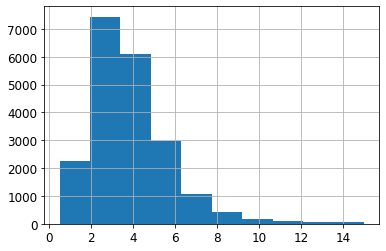

In [10]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

housing["median_income"].hist()

In [11]:
import numpy as np

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [12]:
housing[["median_income","income_cat"]].head()

,median_income,income_cat
0,8.3252,5
1,8.3014,5
2,7.2574,5
3,5.6431,4
4,3.8462,3


<AxesSubplot:>

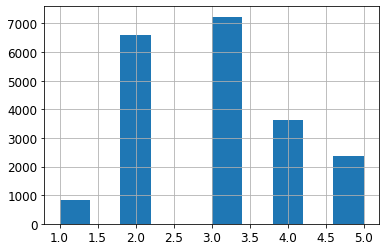

In [13]:
housing["income_cat"].hist()

In [14]:
# Split the data into a training and test set using a stratified sampling approach.
# The income_cat determines the strata in our dataset
# StratifiedShuffleSplit, ensures that the proportion of distribution of class labels is almost even between 
# training and test sets
# random_state=42 is used to guarantee reproducable results
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [15]:
# Evaluate whether our test set is representitive enough of the original dataset to give a good indivation of 
# how well the model we develop will do in reality
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [16]:
# Drop the strata attribute so that it will not be available as a feature for our model.
# Side note: Trailing underscore is used in set_ to distinguish it from Python's 'set' keyword
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 4. Explore the data

In [17]:
# We need to make sure not to include the test data in any exploratory analysis
housing = strat_train_set.copy()

In [18]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000


In [20]:
housing["ocean_proximity"].describe()

count         16512
unique            5
top       <1H OCEAN
freq           7276
Name: ocean_proximity, dtype: object

/Users/thordis.thorsteins/opt/miniconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

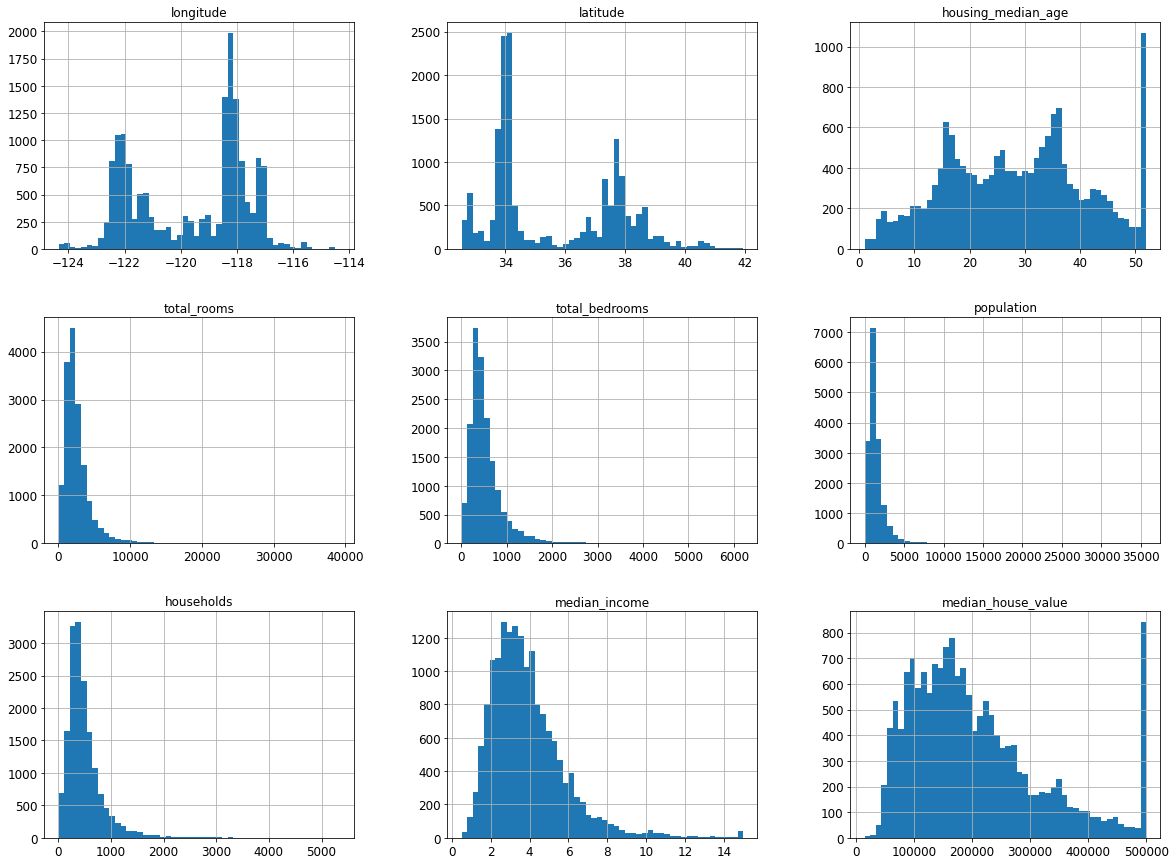

In [19]:
housing.hist(bins=50, figsize=(20,15))

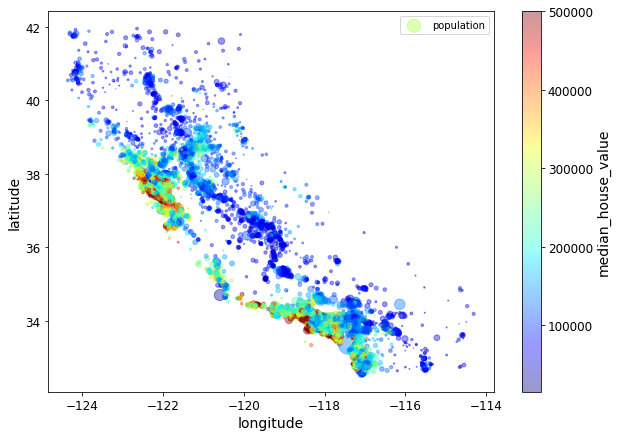

In [24]:
# Look at how median_house_value ranges depending on geographical location and population in the district
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

In [25]:
# Look at correlation between variables
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [26]:
# Focus in on correlation to the median_house_value (the value we want to predict)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [ ]:
# Warning: the correlation coefficient only measures liner correlation, so we might miss non-linear relationships.

/Users/thordis.thorsteins/opt/miniconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

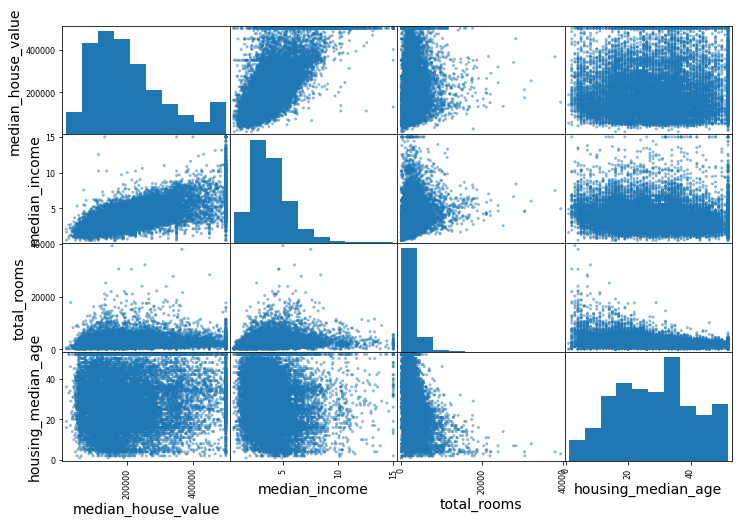

In [27]:
# Understand values better: Plot the 3 example attributes against median_house_value 
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

(0.0, 16.0, 0.0, 550000.0)

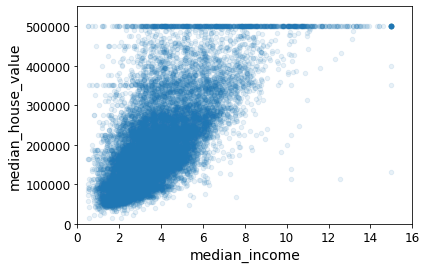

In [28]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

# 5. Data prep

In [ ]:
# 5.1: Look at attribute combinations. These can provide additional insights

# Here, we take a look at the number of rooms per household, proportion of rooms that are bedrooms
# and population per household

In [29]:
# Create new combined attributes from existing attributes
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [30]:
# Calculate correlation again, now also with the combined attributes
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [31]:
# These combined attributes are more strongly correlated with the median house value than the input attributes

# To make it easy to test whether including these combined attributes improves performance, we add them via a 
# function with a hyperparameter. To make this compatible with SciKit-Learn pipelines, we wrap this in a 
# custom transformer. 
# Here, we only have one hyperparameter - for the inclusion of bedrooms_per_room - for demonstration purposes

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [32]:
# 5.2: Separate predictors from the labels
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [33]:
# 5.3: Handle missing data
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# Need to remove non-numeric attributes before we calculate the median
housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [34]:
housing_num.median()

longitude             -118.5100
latitude                34.2600
housing_median_age      29.0000
total_rooms           2119.5000
total_bedrooms         433.0000
population            1164.0000
households             408.0000
median_income            3.5409
dtype: float64

In [35]:
# Use the calculated medians to replace missing values
X = imputer.transform(housing_num)

In [ ]:
# 5.4: Handling attributes that are not numeric

In [36]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7276
INLAND             5263
NEAR OCEAN         2124
NEAR BAY           1847
ISLAND                2
dtype: int64

In [37]:
# Since these categorical values do not have a linear order, we use one-hot encoding to
# translate these categories to numeric values

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [38]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [39]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
# 5.5: Feature scaling

In [40]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
scaled_X = std_scaler.fit_transform(X)

scaled_X

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.63621141,
        -0.42069842, -0.61493744],
       [-1.17602483,  0.6596948 , -1.1653172 , ..., -0.99833135,
        -1.02222705,  1.33645936],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.43363936,
        -0.0933178 , -0.5320456 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.60790363,
         0.71315642, -0.3167053 ],
       [ 0.78221312, -0.85106801,  0.18664186, ..., -0.05717804,
        -0.37545069,  0.09812139],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.13515931,
         0.3777909 , -0.15779865]])

In [ ]:
# Finally, we put this all together into a pipeline

In [41]:
# First, we construct a pipeline that performs all the transformations required for the numerical columns
# (Fill in missing values, add combined attributes and scale the features)
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [42]:
# Then, we use a ColumnTransformer to apply all necessary transformations to numeric and non-numeric columns alike 
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

## 6. Select and train a model

In [43]:
# Start simple
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [44]:
# let's see how the model performs on a few instances of the training set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [45]:
# Calculate the RMSE for the training set
# Keep in mind that median_housing_values typically range between $120k and $265k
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [ ]:
# Model is underfitting the training data.
# We can try adding more features or trying a more complex model.
# We start with the latter option here. Let's try a decision tree

In [46]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [47]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [ ]:
# Too good to be true. Let's investigate whether we're overfitting the training data.
# We use Scikit-learn's K-fold cross validation to do this

In [48]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [49]:
# Let's see how well it performs on the cross validation sets
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


In [50]:
# To compare: Let's try the same with linear regression models
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798342


In [51]:
# Lastly, let's try a random forest model. 
# Random forests build on top of multiple decision trees. This is an example of Ensemble learning
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [52]:
# Calculate the RMSE on the training set
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [53]:
# Calculate the RMSE on cross validation sets
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


In [54]:
# Example info about that we can get about the model
feature_importances = forest_reg.feature_importances_
feature_importances

array([5.85504303e-02, 5.55968201e-02, 4.55908711e-02, 1.32067252e-02,
       1.20147085e-02, 1.20432218e-02, 1.23487680e-02, 4.74028376e-01,
       2.78018554e-02, 1.21708577e-01, 2.28705033e-02, 1.28302714e-03,
       1.39862001e-01, 8.71257918e-05, 7.61315126e-04, 2.24567434e-03])

In [55]:
# Link the importance to the names of the features
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.4740283760125151, 'median_income'),
 (0.13986200065092022, 'INLAND'),
 (0.12170857719944457, 'pop_per_hhold'),
 (0.05855043033160663, 'longitude'),
 (0.055596820114349986, 'latitude'),
 (0.04559087109539425, 'housing_median_age'),
 (0.027801855433835836, 'rooms_per_hhold'),
 (0.022870503252338154, 'bedrooms_per_room'),
 (0.01320672515901517, 'total_rooms'),
 (0.012348768041339732, 'households'),
 (0.012043221835583314, 'population'),
 (0.012014708471689214, 'total_bedrooms'),
 (0.002245674340857851, 'NEAR OCEAN'),
 (0.0012830271428516, '<1H OCEAN'),
 (0.0007613151264602001, 'NEAR BAY'),
 (8.712579179819972e-05, 'ISLAND')]

In [ ]:
# Save model
import joblib

joblib.dump(forest_reg, "random_forest_regression_model.plk")

# 7. Fine tune the model

In [56]:
# Use GridSearch CV to try out different hyperparameter combinations
# n_estimators: The number of trees in the forest
# max_features: The number of features to consider at each split (each tree starts with max_features randomly
# chosen features so the resulting model for that tree can have at most max_features number of features).
# bootstrap: Whether bootstrap samples are used when building trees. If False, the whole dataset is used 
# to build each tree. (from scikit-learn documentation)
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

# Reveal time. Which parameters performed best?
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [57]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [ ]:
# At this point, we could attempt to improve the performance better by exploring further model combinations
# (ensemble methods), but we'll leave this for a later chapter

In [58]:
# Attributes and their importance in our selected model
feature_importances = grid_search.best_estimator_.feature_importances_

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

In [59]:
# Moment of truth: Evaluate the model on the test set
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

47730.22690385927

In [60]:
# For assurance, let's review the 95% confidence interval for the generalization error
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

## Exercises

In [ ]:
# 1. Support vector machine

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR()
svm_reg.fit(housing_prepared, housing_labels)

In [ ]:
# Takes too long to run for the session
param_grid = [
    {'kernel': ["linear"], 'C': [1, 5, 10, 50, 100]},
    {'kernel': ["rbf"], 'C': [1, 5, 10, 50], 'gamma': [1,5]},
  ]

svm_reg = SVR()
# train across 5 folds, that's a total of (5+4*3)*5=85 rounds of training 
grid_search = GridSearchCV(svm_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

# Reveal time. Which parameters performed best?
grid_search.best_params_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
# 2. RandomizedSearchCV

In [ ]:
# Takes too long to run for the session
from sklearn.model_selection import RandomizedSearchCV

svm_reg = SVR()
# train across 5 folds, that's a total of (5+4*3)*5=85 rounds of training 
randomised_search = RandomizedSearchCV(svm_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

# Reveal time. Which parameters performed best?
randomised_search.best_params_

In [ ]:
# 3. Create a transformer that only selects the most important attributes

In [61]:
# Note from solution: this feature selector assumes that you have already computed the feature importances somehow.
# We had saved the feature importance scores for our chosen model under feature_importances, so we will use that here
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class MostImportantAttribs(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k_features_to_choose): 
        self.feature_importances = feature_importances
        self.k_features_to_choose = k_features_to_choose
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k_features_to_choose)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [62]:
# Add the transformer to a new pipeline. First we perform all the transformations of
# full_pipeline, and then we select the top 10 features
k_features = 5

new_prepare_pipeline = Pipeline([
        ('prepare_features', full_pipeline),
        ('select_features', MostImportantAttribs(feature_importances, k_features))
    ])

new_prepare_pipeline.fit_transform(housing)

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ],
       ...,
       [ 1.58648943, -0.72478134, -0.3167053 , -0.03055414,  1.        ],
       [ 0.78221312, -0.85106801,  0.09812139,  0.06150916,  0.        ],
       [-1.43579109,  0.99645926, -0.15779865, -0.09586294,  0.        ]])

In [63]:
# Compare with the output of the original full_pipeline
top_k_feature_indices = indices_of_top_k(feature_importances,5)
housing_prepared[:, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ],
       ...,
       [ 1.58648943, -0.72478134, -0.3167053 , -0.03055414,  1.        ],
       [ 0.78221312, -0.85106801,  0.09812139,  0.06150916,  0.        ],
       [-1.43579109,  0.99645926, -0.15779865, -0.09586294,  0.        ]])

In [64]:
sorted(zip(feature_importances, attributes), reverse=True)[:k_features]

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude')]

In [ ]:
# 4. Combine full data prep and final prediction into a single pipeline

In [65]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [66]:
k_features = 10

prepare_and_predict_pipeline = Pipeline([
        ('prepare_features', full_pipeline),
        ('select_features', MostImportantAttribs(feature_importances, k_features)),
        ('predict', RandomForestRegressor(**grid_search.best_params_))
    ])

prepare_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('prepare_features',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
               

In [67]:
prepare_and_predict_pipeline.predict(some_data)

array([276880.        , 306703.33333333, 230750.        ,  50793.33333333,
       239326.66666667])

In [68]:
list(some_labels)

[286600.0, 340600.0, 196900.0, 46300.0, 254500.0]

In [ ]:
# 5: Pulling it all together - Automatically explore some preparation using GridSearchCV

In [ ]:
# This code takes too long to run in the session
#
# preparation__num__imputer__strategy tries out different strategies for filling in missing data
# feature_selection__k tries different values for k when choosing the k most important fatures
#
# To recap, we have:
#
# prepare_and_predict_pipeline = Pipeline([
#        ('prepare_features', full_pipeline),
#        ('select_features', MostImportantAttribs(feature_importances, k_features)),
#        ('predict', RandomForestRegressor(**grid_search.best_params_))
#    ])
#
# and
#
# full_pipeline = ColumnTransformer([
#        ("num", num_pipeline, num_attribs),
#        ("cat", OneHotEncoder(), cat_attribs),
#    ])
#
# and 
# 
# num_pipeline = Pipeline([
#        ('imputer', SimpleImputer(strategy="median")),
#        ('attribs_adder', CombinedAttributesAdder()),
#        ('std_scaler', StandardScaler()),
#    ])
#
# prepare_features__num__imputer__strategy refers to the strategy of the imputer of the "num" transformer
# of the prepare_features pipeline. Double underscores are required for the grid search to access parameters of 
# the transformers
# Further explaination: https://stackoverflow.com/a/61830505
param_grid = [{
    'prepare_features__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'select_features__k_features': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)
